In [30]:
import numpy as np
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit
from qiskit import ClassicalRegister, QuantumRegister
import matplotlib.pyplot as plt

In [31]:
def sim_sv(qc,text):
    """Get the statevecor of the output of the circuit qc"""
    #import libs
    from qiskit_textbook.tools import vector2latex
    from qiskit import Aer, execute
    from qiskit.quantum_info import Statevector
    #code
    sv_sim = Aer.get_backend('statevector_simulator')
    sv = execute (qc, sv_sim).result().get_statevector()
    #vector2latex(sv, pretext = "|"+ text + "\\rangle =")
    return sv

In [32]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    for i in range (n):
        circuit.h(i)
        m = 1
        for j in range (i+1,n):
            m = m +1; 
            circuit.cu1(-2*pi/2**(m), i, j)

In [33]:
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

In [34]:
def makeQFTgate(N):
    """returns a gate of centred QFT, swaps qubits"""
    temp = QuantumCircuit (N)
    swap_registers(temp, N)
    qft_rotations(temp,N)
    temp.x(n-1);
    QFTC = temp.to_gate()
    QFTC.name = "QFT_" + str(N) 
    return QFTC

In [35]:
def phase(n, phi):
    """returns the phase transformation gate for n qubits"""
    qc = QuantumCircuit(n+1);
    for i in range (n):
        qc.u1(phi/(2**(i+n-3)), n-1-i)
    for i in range (n):
        for j in range (i+1,n):
            qc.cx(n-1-j, n)
            qc.cx(n-1-i, n)
            qc.u1(phi* (2**(2-i-j)), n) #2-i-j or 4?
            qc.cx(n-1-i, n)
            qc.cx(n-1-j, n)
    phcirc = qc.to_gate()
    phcirc.name = 'phase'+str(phi)
    return phcirc

In [36]:
def phaselinear(n, phi):
    """returns the phase transformation gate for n qubits"""
    qc = QuantumCircuit(n+1);
    for i in range (n):
        qc.u1(phi/(2**(i+n-3)), n-1-i)
    phcirc = qc.to_gate()
    phcirc.name = 'phase'+str(phi)
    return phcirc

In [37]:
def evolve (n,phi,initial_state, stepsnumber):
    ## make the circuit
    n1 = n+1
    snaps = []
    m = 2**7
    #qubits
    for i in range (stepsnumber):
        q = QuantumRegister(n1)
        qc = QuantumCircuit(q)
        qc.barrier();
        #initialization
        magnitude = np.linalg.norm(initial_state)
        initial_state =initial_state/magnitude
        qc.initialize(initial_state, list(range(n))) 
        qc.barrier();
        #gates
        QFT = makeQFTgate(n)
        phkinetic = phase (n,(i+1)*phi/m)
        QFTi = QFT.inverse()
        QFTi.name = "QFTi_" + str(n)
        phpotential = phaselinear (n,((i+1)*10*phi)/m)
        for j in range (m):
            #QFT
            qc.append(QFT,range(n))
            qc.barrier();
            #phase
            qc.append(phkinetic,range(n+1))
            qc.barrier();
            #inverse QFT
            qc.append(QFTi,list(range(n)))
            qc.barrier()
            #another phase for the harmonic potential
            qc.append(phpotential,range(n+1))
        finalstate = sim_sv(qc,'\psi')
        prob = np.square(abs(finalstate))
        snaps.append(prob)
    return snaps

In [38]:
def action ():
    snaps = evolve(n,phi,initial_state, stepsnumber)
    plt.plot(np.square(abs(initial_state)),'r')
    leg = ["initial"]
    for i in range (stepsnumber):
        plt.plot(snaps[i])
        leg. append ("step_"+str(i+1))
    x=plt.axis([0, 2**n-1, 0, 1.1*max(np.square(abs(initial_state)))])
    plt.legend(leg)
    return snaps

<ipython-input-32-0c66c7830e4a>:8: DeprecationWarning: The QuantumCircuit.cu1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cp method instead, which acts identically.
  circuit.cu1(-2*pi/2**(m), i, j)
<ipython-input-35-83749b56519e>:5: DeprecationWarning: The QuantumCircuit.u1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.p method instead, which acts identically.
  qc.u1(phi/(2**(i+n-3)), n-1-i)


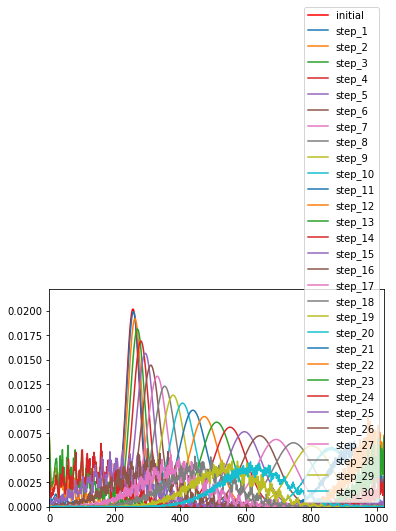

In [39]:
##parameters
n = 10; ## number of qubits
phi = 50*pi; ##time of evolution 
width= 14*2; ## 14*2 works so well centered non moving gaussian 
             ## 15.2 what works so well for coherent state oscillation with n = 10 and width  phi = 200 * pi
             
#initial_state = (np.exp(-(np.linspace(0,2**n-1, 2**n) - (2**n/2) +0.5)**2/(2*width**2))) # n Centred Gaussian
initial_state = (np.exp(-(np.linspace(0,2**n-1, 2**n) - 2**n/4 +0.5)**2/(2*width**2))) # n quarter figure Centred Gaussian
## ground state of harmonic oscillator

#initial_state = (np.exp(-(np.linspace(0,2**n-1, 2**n) )**2/(2*width**2))) + (np.exp(-(np.linspace(0,2**n-1, 2**n) -2**n)**2/(2*width**2)))
## removed the sqrt what an error

#initial_state = np.sqrt(np.exp(-(np.linspace(0,2**n-1, 2**n) - (2**n/3) +0.5)**2/(2*15**2)))+np.sqrt(np.exp(-(np.linspace(0,2**n-1, 2**n) - (2*2**n/3) +0.5)**2/(2*15**2)))
# coherent state
#initial_state = np.sqrt(np.exp(-(np.linspace(0,2**n-1, 2**n) - (2**n/3) +0.5)**2/(2*15.2**2))) ## biased gaussian 

##general energy state 
#w=2 #harmonic
#mom = np.zeros(2**n);
#mom[w]=1
#mom [2**n-w]=1
#initial_state= np.fft.fft(mom,2**n)
magnitude = np.linalg.norm(initial_state)
initial_state =initial_state/magnitude


stepsnumber = 30; 
snaps=action()

# put x back and recentered the quassian


In [40]:
from matplotlib.animation import FuncAnimation

In [41]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

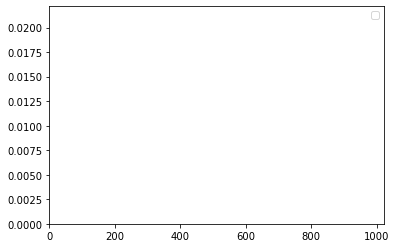

In [42]:

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( 0, (2**n)-1))
ax.set_ylim((0, 1.1*max(np.square(abs(initial_state)))))
plt.legend("step_")

line, = ax.plot([], [], lw=2)

In [43]:
# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    plt.legend([])
    return (line,)

In [44]:
# animation function. This is called sequentially
def animate(i):
    #x = np.linspace(0, 1, 2**(n+1))
    x = list(range(2**(n+1)))
    y = snaps[i]
    line.set_data(x, y)
    return (line,)

In [45]:
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=stepsnumber, interval=100)

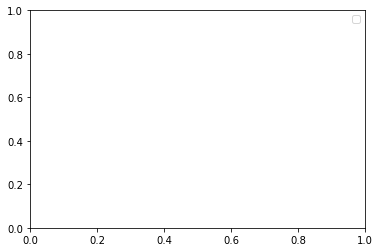

In [46]:
HTML(anim.to_html5_video())

In [47]:
    n=10
    x = np.linspace(0,2**n-1, 2**n) 
    y = (x-2**(n-1))**2/100

Text(0, 0.5, 'V(x)')

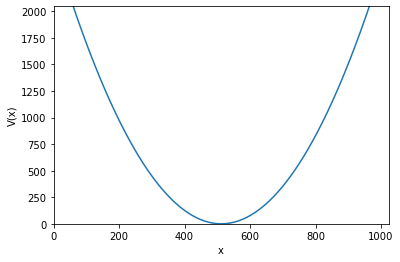

In [48]:
plt.plot(y)
plt.axis([0, 2**n-1, 0, 2*2**n-1])
plt.xlabel('x')
plt.ylabel('V(x)')
